In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import re

In [ ]:
# Load and preprocess the data
df = pd.read_csv("../data/output/stats.csv", delimiter="\t")
df.columns = df.columns.str.strip()
cols_of_interest = ['Sec30', 'Sec60', 'Sec90', 'Sec120', 'Tipo', 'Esperto', 'Audio']
df_subset = df[cols_of_interest].copy()
for col in ['Sec30', 'Sec60', 'Sec90', 'Sec120']:
    df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce')

(df_subset[['columns']] != 0).all(axis=1)


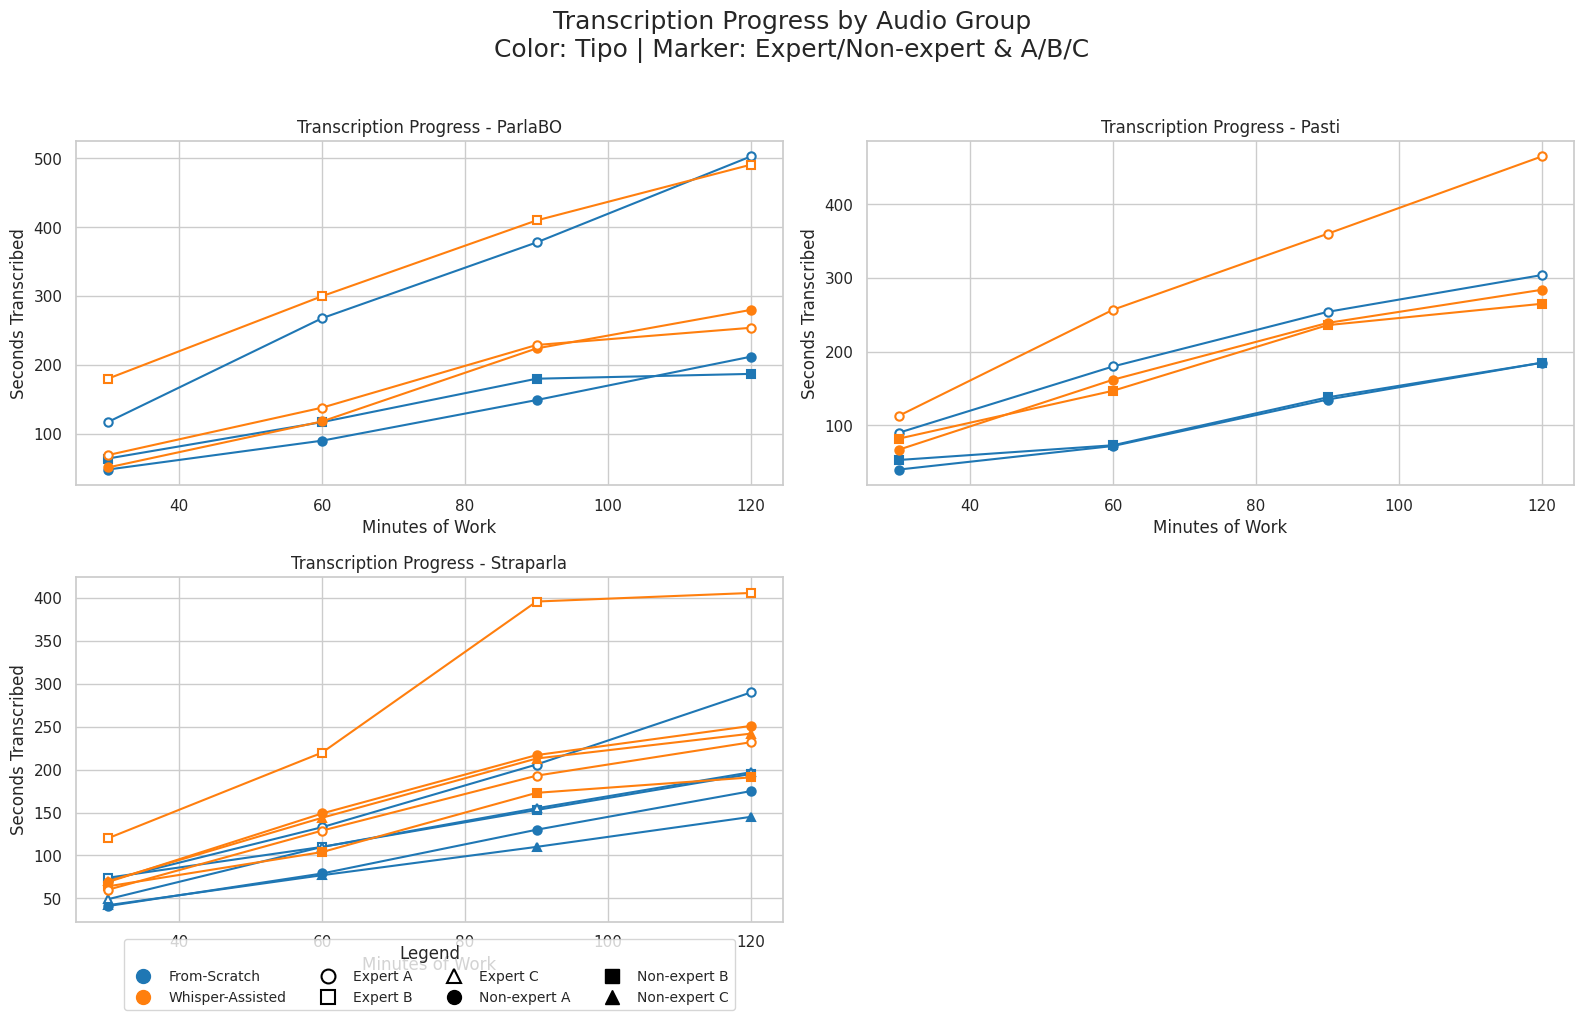

In [4]:
grouped_stats = df_subset.groupby(['Tipo', 'Esperto', 'Audio']).mean(numeric_only=True).reset_index()
grouped_stats = grouped_stats[grouped_stats['Tipo'] != 'Revised']

# Prepare melted DataFrame
melted = pd.melt(
    grouped_stats,
    id_vars=['Tipo', 'Esperto', 'Audio'],
    value_vars=['Sec30', 'Sec60', 'Sec90', 'Sec120'],
    var_name='Time',
    value_name='TranscribedSeconds'
)
melted['Minutes'] = melted['Time'].str.extract('(\d+)').astype(int)

# Group similar audios
def group_audio(audio_name):
    match = re.match(r"([A-Za-z]+(?:[A-Z]{2})?)", audio_name)
    return match.group(1) if match else audio_name

melted['AudioGroup'] = melted['Audio'].apply(group_audio)

def extract_version(audio_name):
    match = re.search(r'_([ABC])$', audio_name)
    return match.group(1) if match else 'A'

melted['AudioVersion'] = melted['Audio'].apply(extract_version)

# Plot settings
sns.set(style="whitegrid")
color_map = {
    "From-Scratch": "tab:blue",
    "Whisper-Assisted": "tab:orange"
}
marker_style_map = {
    ('sì', 'A'): ('o', 'none'),     # Expert A - empty circle
    ('sì', 'B'): ('s', 'none'),     # Expert B - empty square
    ('sì', 'C'): ('^', 'none'),     # Expert C - empty triangle
    ('no', 'A'): ('o', 'full'),     # Non-expert A - filled circle
    ('no', 'B'): ('s', 'full'),     # Non-expert B - filled square
    ('no', 'C'): ('^', 'full')      # Non-expert C - filled triangle
}

# Plot one chart per audio group
unique_groups = melted['AudioGroup'].unique()
cols = 2
rows = (len(unique_groups) + 1) // cols
plt.figure(figsize=(16, 5 * rows))

for i, group in enumerate(unique_groups, 1):
    plt.subplot(rows, cols, i)
    subset = melted[melted['AudioGroup'] == group]
    for key, grp in subset.groupby(['Tipo', 'Esperto', 'Audio', 'AudioVersion']):
        tipo, esperto, audio, version = key
        label = f"{esperto}-{version}-{audio}"
        color = color_map.get(tipo, 'gray')
        marker, fill = marker_style_map.get((esperto, version), ('x', 'full'))
        facecolor = 'white' if fill == 'none' else color
        edgecolor = color

        plt.plot(
            grp['Minutes'],
            grp['TranscribedSeconds'],
            label=label,
            color=color,
            marker=marker,
            markerfacecolor=facecolor,
            markeredgecolor=edgecolor,
            markeredgewidth=1.5,
            linestyle='-'
        )
    plt.title(f"Transcription Progress - {group}")
    plt.xlabel("Minutes of Work")
    plt.ylabel("Seconds Transcribed")
    plt.grid(True)
    plt.tight_layout()

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='tab:blue', label='From-Scratch', markersize=10, linestyle=''),
    Line2D([0], [0], marker='o', color='tab:orange', label='Whisper-Assisted', markersize=10, linestyle=''),
    Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert A', linestyle='', markersize=10),
    Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert B', linestyle='', markersize=10),
    Line2D([0], [0], marker='^', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert C', linestyle='', markersize=10),
    Line2D([0], [0], marker='o', color='black', markerfacecolor='black', label='Non-expert A', linestyle='', markersize=10),
    Line2D([0], [0], marker='s', color='black', markerfacecolor='black', label='Non-expert B', linestyle='', markersize=10),
    Line2D([0], [0], marker='^', color='black', markerfacecolor='black', label='Non-expert C', linestyle='', markersize=10),
]

plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=4, fontsize='small', title="Legend")
plt.suptitle("Transcription Progress by Audio Group\nColor: Tipo | Marker: Expert/Non-expert & A/B/C", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

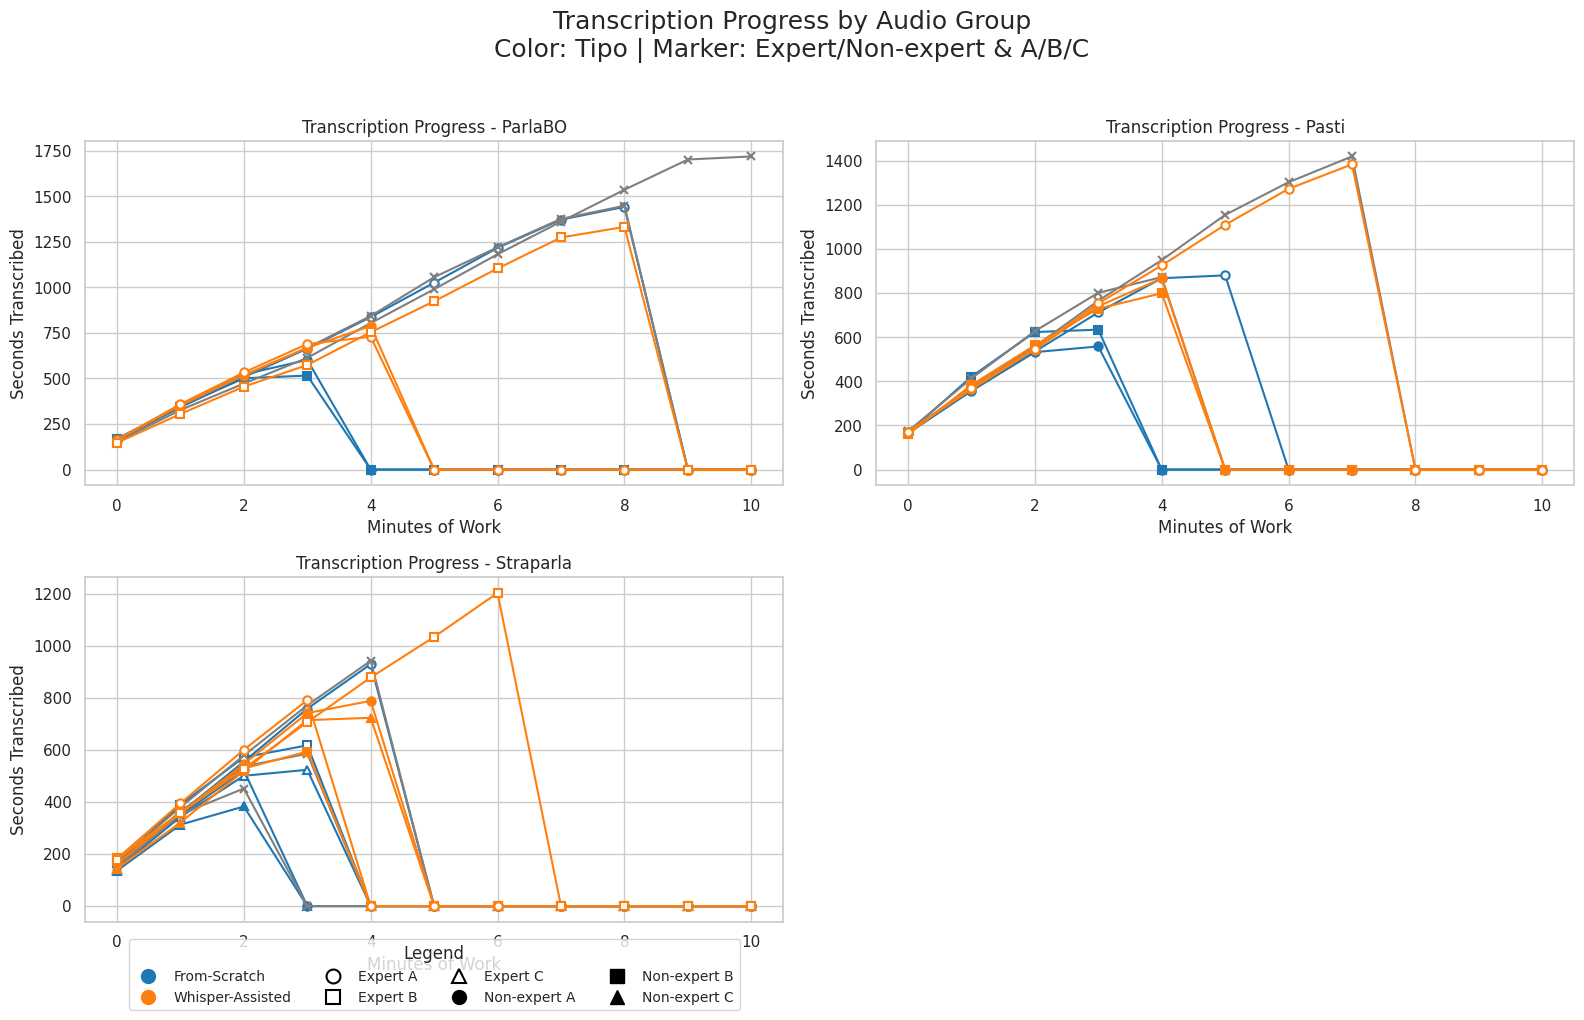

In [12]:
grouped_stats = df.groupby(['Tipo', 'Esperto', 'Audio']).mean(numeric_only=True).reset_index()

# Prepare melted DataFrame
melted = pd.melt(
    grouped_stats,
    id_vars=['Tipo', 'Esperto', 'Audio'],
    value_vars=[f"tokens_per_minute::{i}" for i in range(0,11)],
    var_name='Time',
    value_name='TranscribedTokens'
)
melted['Minutes'] = melted['Time'].str.extract('(\d+)').astype(int)

# Group similar audios
def group_audio(audio_name):
    match = re.match(r"([A-Za-z]+(?:[A-Z]{2})?)", audio_name)
    return match.group(1) if match else audio_name

melted['AudioGroup'] = melted['Audio'].apply(group_audio)

def extract_version(audio_name):
    match = re.search(r'_([ABC])$', audio_name)
    return match.group(1) if match else 'A'

melted['AudioVersion'] = melted['Audio'].apply(extract_version)

# Plot settings
sns.set(style="whitegrid")
color_map = {
    "From-Scratch": "tab:blue",
    "Whisper-Assisted": "tab:orange",
    "Revised": "tab:gray"
}
marker_style_map = {
    ('sì', 'A'): ('o', 'none'),     # Expert A - empty circle
    ('sì', 'B'): ('s', 'none'),     # Expert B - empty square
    ('sì', 'C'): ('^', 'none'),     # Expert C - empty triangle
    ('no', 'A'): ('o', 'full'),     # Non-expert A - filled circle
    ('no', 'B'): ('s', 'full'),     # Non-expert B - filled square
    ('no', 'C'): ('^', 'full')      # Non-expert C - filled triangle
}

# Plot one chart per audio group
unique_groups = melted['AudioGroup'].unique()
cols = 2
rows = (len(unique_groups) + 1) // cols
plt.figure(figsize=(16, 5 * rows))

for i, group in enumerate(unique_groups, 1):
    plt.subplot(rows, cols, i)
    subset = melted[melted['AudioGroup'] == group]
    for key, grp in subset.groupby(['Tipo', 'Esperto', 'Audio', 'AudioVersion']):
        tipo, esperto, audio, version = key
        label = f"{esperto}-{version}-{audio}"
        color = color_map.get(tipo, 'gray')
        marker, fill = marker_style_map.get((esperto, version), ('x', 'full'))
        facecolor = 'white' if fill == 'none' else color
        edgecolor = color

        plt.plot(
            grp['Minutes'],
            grp['TranscribedTokens'],
            label=label,
            color=color,
            marker=marker,
            markerfacecolor=facecolor,
            markeredgecolor=edgecolor,
            markeredgewidth=1.5,
            linestyle='-'
        )
    plt.title(f"Transcription Progress - {group}")
    plt.xlabel("Minutes of Work")
    plt.ylabel("Seconds Transcribed")
    plt.grid(True)
    plt.tight_layout()

# Custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='tab:blue', label='From-Scratch', markersize=10, linestyle=''),
    Line2D([0], [0], marker='o', color='tab:orange', label='Whisper-Assisted', markersize=10, linestyle=''),
    Line2D([0], [0], marker='o', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert A', linestyle='', markersize=10),
    Line2D([0], [0], marker='s', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert B', linestyle='', markersize=10),
    Line2D([0], [0], marker='^', color='black', markerfacecolor='white', markeredgewidth=1.5, label='Expert C', linestyle='', markersize=10),
    Line2D([0], [0], marker='o', color='black', markerfacecolor='black', label='Non-expert A', linestyle='', markersize=10),
    Line2D([0], [0], marker='s', color='black', markerfacecolor='black', label='Non-expert B', linestyle='', markersize=10),
    Line2D([0], [0], marker='^', color='black', markerfacecolor='black', label='Non-expert C', linestyle='', markersize=10),
]

plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.03), ncol=4, fontsize='small', title="Legend")
plt.suptitle("Transcription Progress by Audio Group\nColor: Tipo | Marker: Expert/Non-expert & A/B/C", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()